# from UTM to lat,lon

# Map with ellipses

In [382]:
from pyrocko import util, model, io, trace, moment_tensor, gmtpy,orthodrome
from pyrocko import orthodrome as od
from pyrocko.client import catalog
from pyrocko.automap import Map
import pyrocko.moment_tensor as pmt
from pyrocko.plot import mpl_color
from pyrocko.guts import load
# from seiscloud import plot as scp
# from seiscloud import cluster as scc
import numpy as np
import os
# import shutil
import matplotlib.pyplot as plt
import pygmt

In [383]:
workdir='../../clusty_flegrei/'
catdir=os.path.join(workdir,'results_VT')                               
catname=os.path.join(catdir,'cat_trimmed_mean_ccs_dbscan_comb_0.150_3.yaml')               # CHANGE catalogue_flegrei_VLP_gilberto

clusty_events=model.load_events(catname,format='yaml')


In [384]:
cluster_number=[]
for ev in clusty_events:
    if not ev.extras['cluster_number'] in cluster_number:
        cluster_number.append(ev.extras['cluster_number'])

cls = {key: [] for key in cluster_number}
for ev in clusty_events:
    cls[ev.extras['cluster_number']].append(ev)
del cls[-1]     #remove ev not clustered

In [385]:
cls_lat_mean    =[]
cls_lon_mean    =[]
cls_depth_mean  =[]
cls_mag_mean    =[]
cls_lat_std     =[]
cls_lon_std     =[]
cls_depth_std   =[]
cls_mag_std     =[]
cls_lat_all     =[]
cls_lon_all     =[]

for key in cls:
    lat=[]
    lon=[]
    depth=[]
    mag=[]

    for ev in cls[key]:
        lat.append(ev.lat)
        lon.append(ev.lon)
        depth.append(ev.depth)
        mag.append(ev.magnitude)

    lat_mean=np.mean(lat)
    lat_std=np.std(lat)
    
    lon_mean=np.mean(lon)
    lon_std=np.std(lon)
    
    depth_mean=np.mean(depth)
    depth_std=np.std(depth)
    
    mag_mean=np.mean(mag)
    mag_std=np.std(mag)

    cls_lat_all.append(np.array(lat))
    cls_lon_all.append(np.array(lon))
 
    cls_lat_mean.append(lat_mean)
    cls_lon_mean.append(lon_mean)
    cls_depth_mean.append(depth_mean)
    cls_mag_mean.append(mag_mean)

    cls_lat_std.append(lat_std)
    cls_lon_std.append(lon_std)
    cls_depth_std.append(depth_std)
    cls_mag_std.append(mag_std)

cls_lat_mean    =np.array(cls_lat_mean    )
cls_lon_mean    =np.array(cls_lon_mean    )
cls_depth_mean  =np.array(cls_depth_mean  )
cls_mag_mean    =np.array(cls_mag_mean    )
cls_lat_std     =np.array(cls_lat_std     )
cls_lon_std     =np.array(cls_lon_std     )
cls_depth_std   =np.array(cls_depth_std   )
cls_mag_std     =np.array(cls_mag_std     )

In [386]:
azimuth_cls=[]
dist_cls=[]
x_cls=[]
y_cls=[]
depth_cls=[]
for i,key in enumerate(cls):
    x=[]
    y=[]
    depth=[]
    for ev in cls[key]:
        n,e = orthodrome.latlon_to_ne_numpy(cls_lat_mean[i],cls_lon_mean[i],ev.lat,ev.lon)
        x.append( e )
        y.append( n )

        depth.append(ev.depth)

    x_cls.append(x)
    y_cls.append(y)
    depth_cls.append(depth)


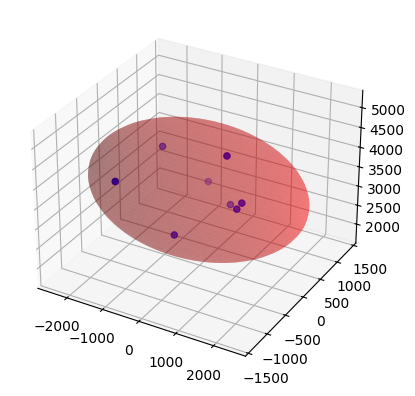

center of ellispe: [3.93083222e-01 5.13476123e-02 3.46412160e+03] 
axis: [2521.51511445 1777.03328892 1200.41316992] 
azimuth [[-55.13679443 -15.45468616  -1.97304976]
 [ -8.8504423   25.09733655  50.74051359]
 [ 12.8222432  -49.13331582  26.53890928]]


In [387]:
import numpy as np
from scipy.stats import chi2

def fit_ellipsoid(points, confidence_level=0.95):
    """
    Trova l'ellissoide che meglio approssima una distribuzione di punti 3D.
    
    Parameters:
    points: numpy.ndarray di shape (n, 3) contenente le coordinate (x,y,z) dei punti
    confidence_level: livello di confidenza per la dimensione dell'ellissoide (default 0.95)
    
    Returns:
    center: centro dell'ellissoide (array 3D)
    radii: lunghezza dei semiassi dell'ellissoide
    rotation: matrice di rotazione dell'ellissoide
    """
    # Calcola il centro come media dei punti
    center = np.mean(points, axis=0)
    
    # Centra i punti sottraendo la media
    centered_points = points - center
    
    # Calcola la matrice di covarianza
    cov_matrix = np.cov(centered_points, rowvar=False)
    
    # Calcola autovalori e autovettori
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    
    # Ordina autovalori e autovettori in ordine decrescente
    idx = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    # Calcola i semiassi dell'ellissoide
    # Usiamo chi-square per determinare la dimensione dell'ellissoide
    chi2_val = chi2.ppf(confidence_level, df=3)
    radii = np.sqrt(eigenvalues * chi2_val)
    
    return center, radii, eigenvectors

def generate_ellipsoid_mesh(center, radii, rotation, n_points=50):
    """
    Genera i punti per visualizzare l'ellissoide.
    
    Parameters:
    center: centro dell'ellissoide
    radii: lunghezza dei semiassi
    rotation: matrice di rotazione
    n_points: numero di punti per la mesh
    
    Returns:
    X, Y, Z: coordinate dei punti della superficie dell'ellissoide
    """
    u = np.linspace(0, 2 * np.pi, n_points)
    v = np.linspace(0, np.pi, n_points)
    
    x = radii[0] * np.outer(np.cos(u), np.sin(v))
    y = radii[1] * np.outer(np.sin(u), np.sin(v))
    z = radii[2] * np.outer(np.ones_like(u), np.cos(v))
    
    # Applica la rotazione
    for i in range(len(x)):
        for j in range(len(x)):
            point = np.array([x[i,j], y[i,j], z[i,j]])
            rotated_point = rotation.dot(point) + center
            x[i,j], y[i,j], z[i,j] = rotated_point
            
    return x, y, z

for i in range(len(x_cls)):
    points=np.zeros((len(x_cls[i]), 3))
    points[:,0]=np.array(x_cls[i]).flatten()
    points[:,1]=np.array(y_cls[i]).flatten()
    points[:,2]=np.array(depth_cls[i]).flatten()


    center, radii, eigenvectors= fit_ellipsoid(points,confidence_level=0.90)
    X,Y,Z= generate_ellipsoid_mesh(center,radii,eigenvectors)

    # Plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(points[:,0], points[:,1], points[:,2], c='b', label='Punti')
    ax.plot_surface(X, Y, Z, alpha=0.3, color='r')
    plt.show()
    print(f'center of ellispe: {center} \naxis: {radii} \nazimuth {eigenvectors * 180 / np.pi}')


main eigenvector -0.9925318004157123 -0.12198616791892702


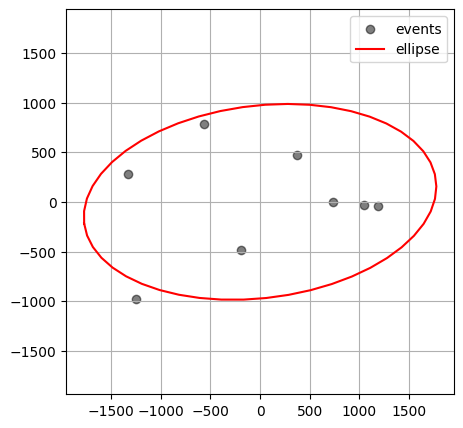

center of ellispe: [0.39308322 0.05134761] 
axis: [1784.4655001   968.80646206] 
rotation -172.99325613226569 
GMT angle -97.00674386773434


In [388]:
import numpy as np
from scipy.stats import chi2

def fit_ellipse_2d(points, confidence_level=0.95):
    """
    Trova l'ellisse che meglio approssima una distribuzione di punti 2D.
    
    Parameters:
    points: numpy.ndarray di shape (n, 2) contenente le coordinate (x,y) dei punti
    confidence_level: livello di confidenza per la dimensione dell'ellisse (default 0.95)
    
    Returns:
    center: centro dell'ellisse (array 2D)
    radii: lunghezza dei semiassi dell'ellisse
    rotation: angolo di rotazione dell'ellisse in radianti
    """
    # Calcola il centro come media dei punti
    center = np.mean(points, axis=0)
    
    # Centra i punti sottraendo la media
    centered_points = points - center
    
    # Calcola la matrice di covarianza
    cov_matrix = np.cov(centered_points, rowvar=False)
    
    # Calcola autovalori e autovettori
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    
    # Ordina autovalori e autovettori in ordine decrescente
    idx = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    # Calcola i semiassi dell'ellisse
    chi2_val = chi2.ppf(confidence_level, df=2)
    radii = np.sqrt(eigenvalues * chi2_val)

    # Calcola l'angolo di rotazione dal primo autovettore
    rotation = np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0])       # arctan( y/x )
    x_main_axis=eigenvectors[0, 0]
    y_main_axis=eigenvectors[1, 0]
    print('main eigenvector',x_main_axis,y_main_axis)

    return center, radii, rotation , x_main_axis ,y_main_axis

def generate_ellipse_points(center, radii, rotation, n_points=50):
    """
    Genera i punti per disegnare l'ellisse.
    
    Parameters:
    center: centro dell'ellisse
    radii: lunghezza dei semiassi
    rotation: angolo di rotazione in radianti
    n_points: numero di punti per disegnare l'ellisse
    
    Returns:
    x, y: array delle coordinate x e y dei punti dell'ellisse
    """
    # Genera punti per un cerchio
    theta = np.linspace(0, 2*np.pi, n_points)
    
    # Crea l'ellisse
    x = radii[0] * np.cos(theta)
    y = radii[1] * np.sin(theta)
    
    # Crea la matrice di rotazione
    rot_matrix = np.array([
        [np.cos(rotation), -np.sin(rotation)],
        [np.sin(rotation), np.cos(rotation)]
    ])
    
    # Applica rotazione e traslazione
    points = np.dot(rot_matrix, np.array([x, y]))
    x = points[0, :] + center[0]
    y = points[1, :] + center[1]
    
    return x, y
ellipse_res=[]
for i in range(len(x_cls)):
    points=np.zeros((len(x_cls[i]), 2))
    points[:,0]=np.array(x_cls[i]).flatten()
    points[:,1]=np.array(y_cls[i]).flatten()

    center, radii, rotation ,x_main_axis ,y_main_axis = fit_ellipse_2d(points,confidence_level=0.80)

    x_ellipse, y_ellipse = generate_ellipse_points(center, radii, rotation)

    plt.figure(figsize=(5, 5))
    plt.scatter(points[:,0], points[:,1], c='k', alpha=0.5, label='events')
    plt.plot(x_ellipse, y_ellipse, 'r-', label='ellipse')
    plt.axis('equal')
    plt.grid(True)
    plt.legend()
    plt.show()

    rotation_angle= rotation * 180 / np.pi
    
    GMT_angle=np.arctan2(x_main_axis,y_main_axis) * 180 / np.pi

    ellipse_res.append( (center,radii,rotation_angle, GMT_angle) )

    print(f'center of ellispe: {center} \naxis: {radii} \nrotation {rotation_angle} \nGMT angle {GMT_angle}')

    

In [389]:
#DO ONE TIME TO CONVERT ANGLES
for i in range(len(ellipse_res)):
    print('angle before: ',ellipse_res[i][3])
    ellipse_res[i]=list(ellipse_res[i])

    if -180<=ellipse_res[i][3]<0:
        ellipse_res[i][3]+= 360
    elif 0<=ellipse_res[i][3]<=180:
        ellipse_res[i][3]+=0
    else:
        print('WARNING: check angles values')
    print('angle after:',ellipse_res[i][3])

#ellipse centre coordinates
new_cls_lat=[]
new_cls_lon=[]
for i in range(len(cls_lat_mean)):
    new_lat,new_lon = orthodrome.ne_to_latlon(cls_lat_mean[i],cls_lon_mean[i],ellipse_res[i][0][1],ellipse_res[i][0][0])
    new_cls_lat.append(new_lat)
    new_cls_lon.append(new_lon)

angle before:  -97.00674386773434
angle after: 262.9932561322656


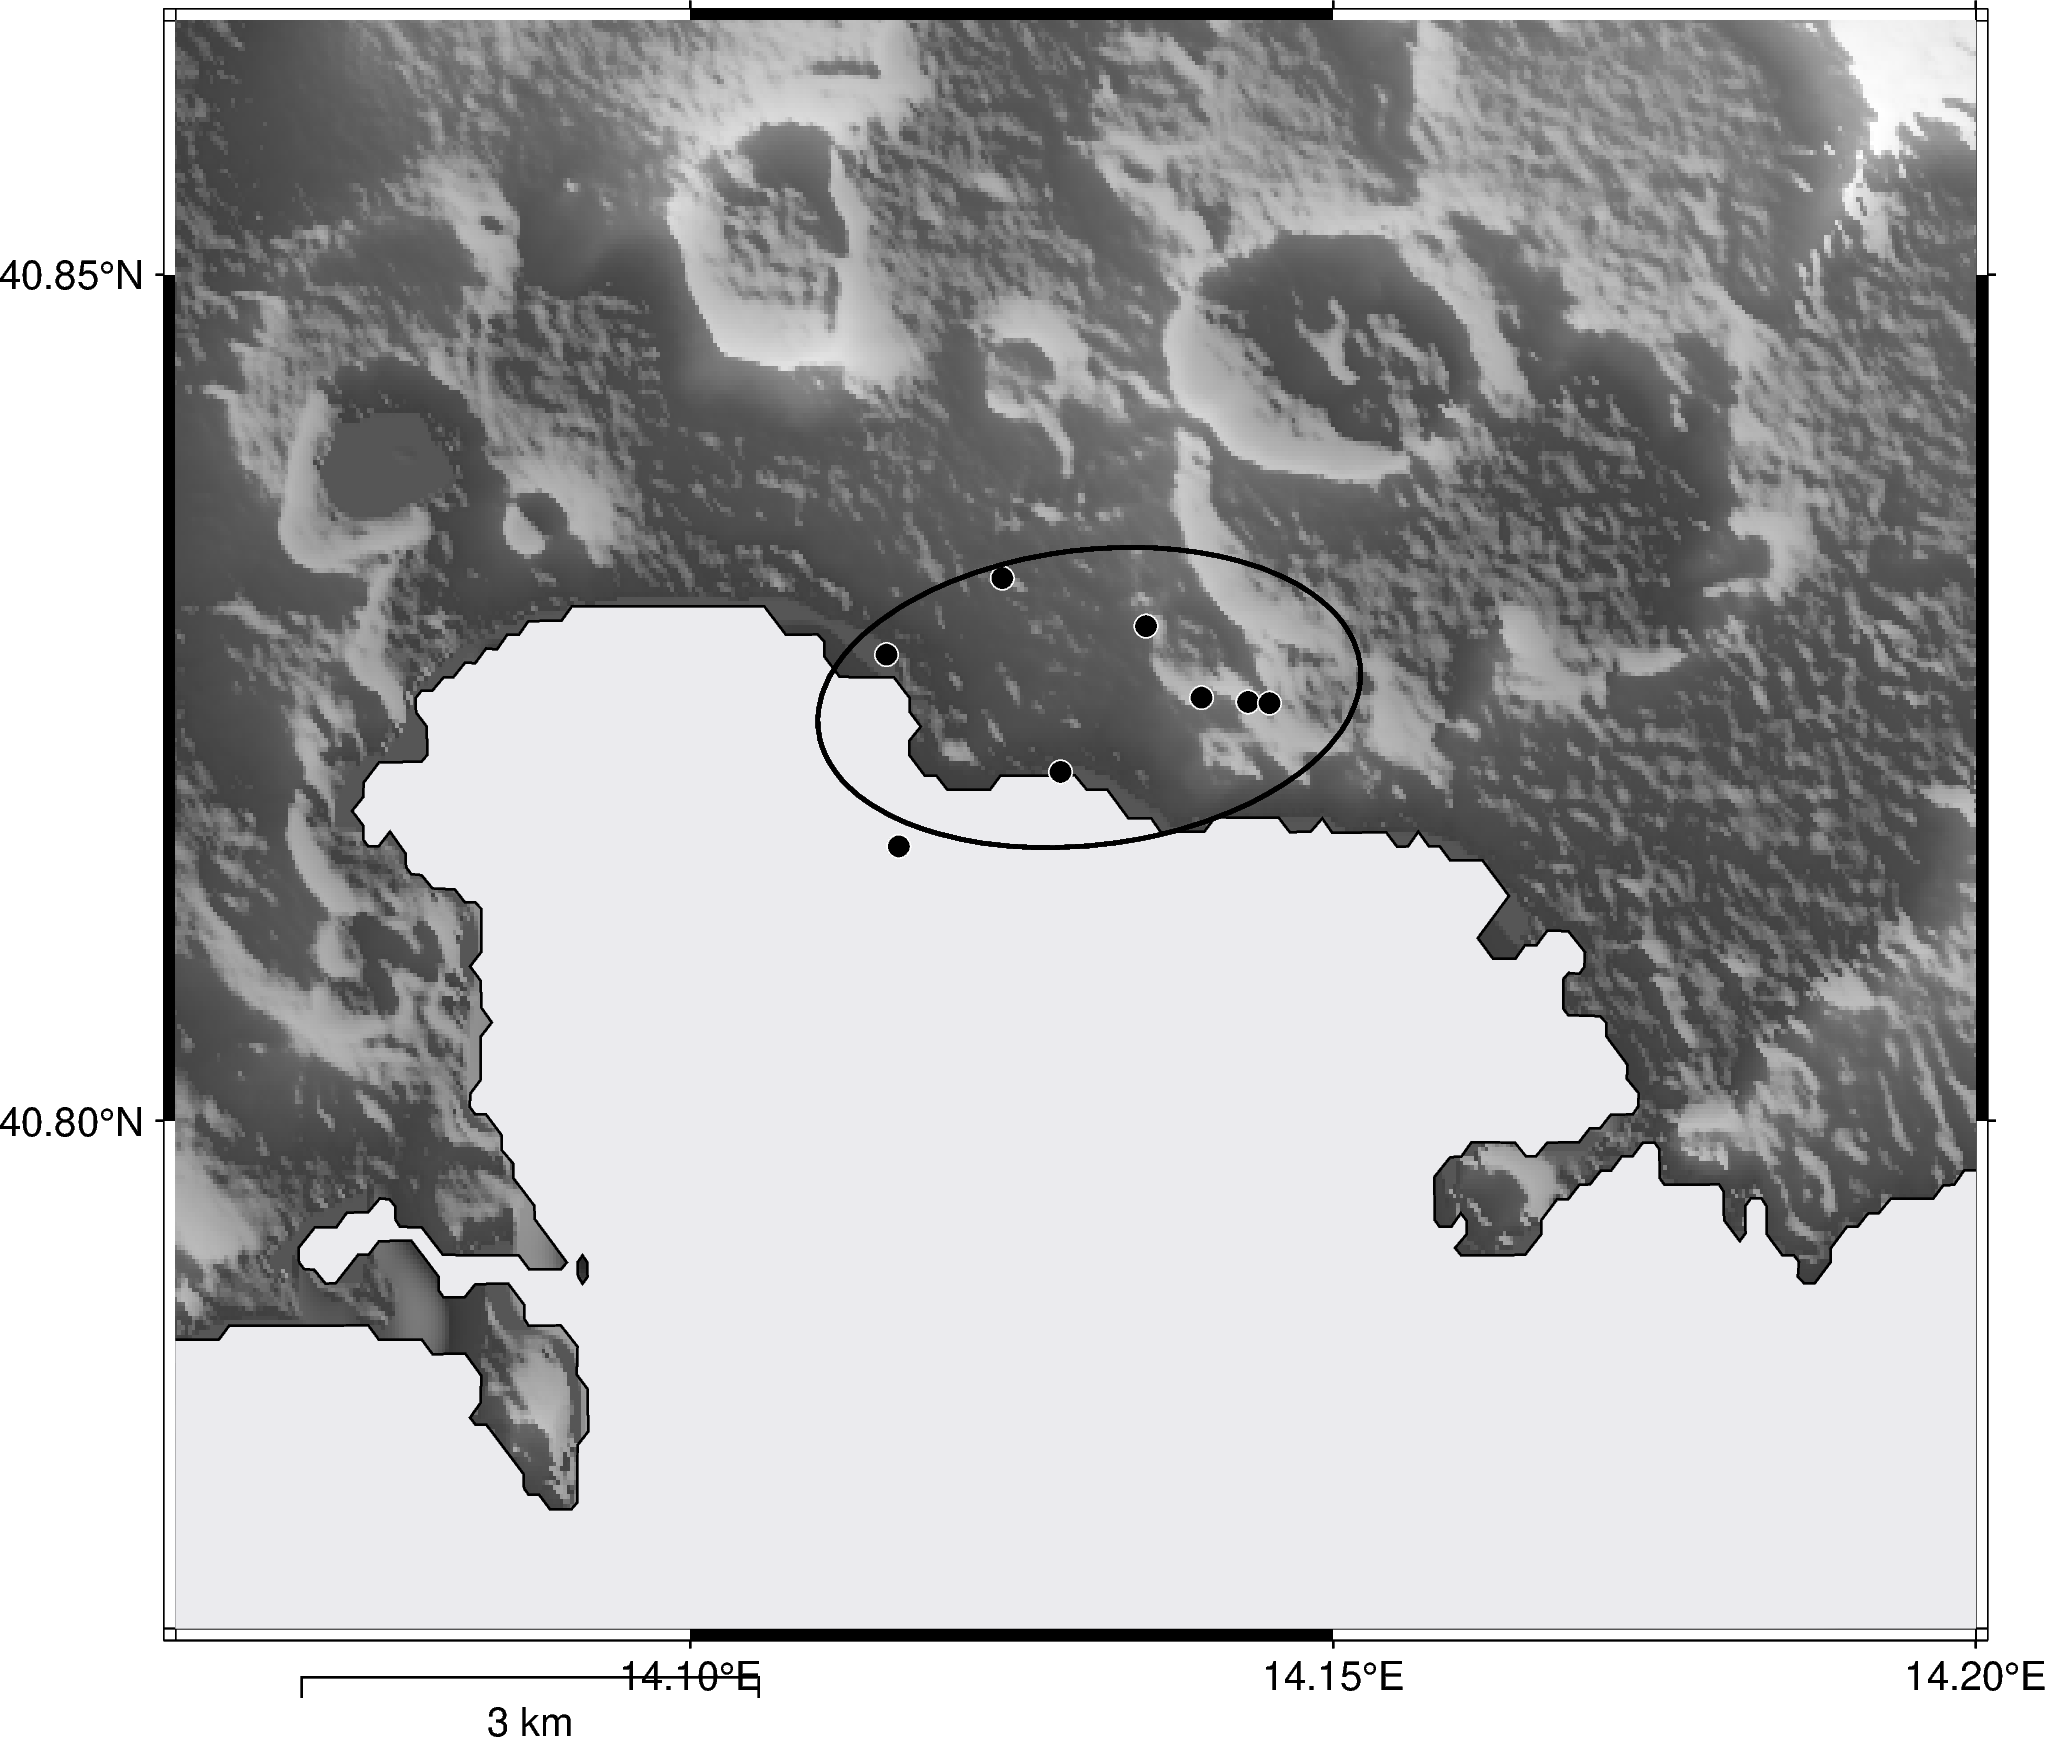

In [390]:
#   CREATE FIGURE
minlon=14.06
maxlon=14.20
minlat=40.77
maxlat=40.865

fig = pygmt.Figure()
pygmt.config(FORMAT_GEO_MAP="ddd.xxF")

# Define the region around the center coordinates (a smaller box for higher resolution)
region = [minlon, maxlon, minlat, maxlat]

# Define the projection
projection = "M6i"  # Mercator projection with a 6-inch width

fig.basemap(region=region,projection=projection, frame='a0.05', map_scale='x3c/-0.5c+w3k+lkm')
# Load high-resolution topography data (1 arc-second resolution)
topo_data = pygmt.datasets.load_earth_relief(resolution="01s", region=region)

# Plot the topography with shading
fig.grdimage(grid=topo_data, region=region, projection=projection, shading="+a45+ne0.5", cmap="gray")
# Plot coastlines with high resolution
fig.coast(shorelines="1/0.5p,black", resolution="f", water="#EBEBEE")

#fig.plot(x=new_cls_lon[:], y=new_cls_lat[:], style="c0.2c", fill="#BD2025", pen="#BD2025", label='centre cluster') # red filling
for i in range(len(cls_lat_all)):
    fig.plot(x=cls_lon_all[i][:], y=cls_lat_all[i][:], style="c0.2c",fill=f"#{i}{i}{i*3}{i*3}{i*6}{i*6}",  pen="white")

for i in range(len(cls_depth_mean)):
    fig.plot(
        x=[new_cls_lon[i]],
        y=[new_cls_lat[i]],
        pen=f"1p,#{i}{i}{i*3}{i*3}{i*6}{i*6}",
        style = f'E{ellipse_res[i][3]}/{ellipse_res[i][1][0]*0.002}/{ellipse_res[i][1][1]*0.002}'       # x0.001 to convert m in KM
                                                                                                        # x2 because of semiaxis conversion
        #style = f'E{ellipse_res[i][2]}/3/3'
        #style = f'E{i*50}/3/0.5'
        #style= 'E10/3/0.5'
    )
fig.show()
fig.savefig('../PLOTS/ellipses_VLP.pdf')